# Liiga - Data Cleaning and Feature Engineering

> *Please note that this notebook is work in progress.*

1. [Scraping and Preprocessing](#1)<br>
    1.1 [Regular season data](#1-1)<br>
    1.2 [Player rankings](#1-2)<br>
    1.3 [Game results](#1-3)<br>
    1.4 [Target variable](#1-4)

This notebook is part of our [series](https://github.com/nlaaksonen/liiga) to build a model to predict
the champion of the Finnish ice hockey league Liiga based on regular season statistics.

In this notebook our aim is to process and clean up the data that we have scraped from [Liiga's official website](https://www.liiga.fi/fi/) and turn it into a form where we can directly feed it into `sklearn` and `XGboost` models. We will also briefly look at some interesting trends visible in the data, but we'll leave a more thorough analysis to the followup notebook.

In [1]:
import numpy as np
import pandas as pd
import pickle
import requests
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup

pd.options.display.max_rows = 15

## 1. Scraping and Preprocessing<a id='1'></a>

There are three main types of data we'll use. These are the statistics after the regular season has finished (ranking, wins, losses, goals, conceded goals etc.), statistics for individual players (mainly goals scored and penalty minutes) and results for individual games of the season (we're mainly interested in the last 3 games of the season for each team).

Each of the above datasets is scraped from the official website with a helper class `LiigaScraper` (by using `requests` and `BeautifulSoup`) that we have built in [liiga_scraper.py](liiga_scraper.py). An example of how to use this class is provided in [scrape_data.py](scrape_data.py). We have already performed the data retrieval beforehand and stored the resulting pandas DataFrame in pickled files (not provided). In this section we'll load this data and process it into a usable form. Finally, we'll also retrieve the data for our target variable (the winner of each season) directly from [Wikipedia](https://en.wikipedia.org/wiki/Liiga).

### 1.1 Regular season data<a id='1-1'></a>

The `LiigaScraper` class stores a single DataFrame that corresponds to one of the types of statistics outlined above (`LiigaScraper.type`) for a given year (i.e. it is the output from a single web page). The pickled file that we load below then contains simply all of these DataFrames concatenated together in a naive way. We'll begin processing our data from there.

In [2]:
series_data_file_name = 'liiga_stats_series_20210530_120928.pkl'

with open(series_data_file_name, 'rb') as f:
    series_data = pickle.load(f)

In [3]:
series_data.describe()

,Rank,Team,Matches,Wins,Draws,Losses,Goals,ConcededGoals,OvertimeWins,Points,PointsPerGame,PP,PK,Year,Series
count,505,505,505,505,505,505,505,505,505,505,505,505,505,505,505
unique,15,25,11,36,23,36,114,125,16,113,144,82,88,40,1
top,9.,Tappara,60,21,8,20,153,136,0,49,"1,000","0,00%","0,00%",2017,runkosarja
freq,40,40,131,34,38,33,14,12,78,15,14,416,416,15,505


In [4]:
series_data.head()

,Rank,Team,Matches,Wins,Draws,Losses,Goals,ConcededGoals,OvertimeWins,Points,PointsPerGame,PP,PK,Year,Series
0,1.,Tappara,36,26,2,8,184,115,-,54,"1,500","0,00%","0,00%",1980,runkosarja
1,2.,TPS,36,22,5,9,213,141,-,49,"1,360","0,00%","0,00%",1980,runkosarja
2,3.,Kärpät,36,23,3,10,196,129,-,49,"1,360","0,00%","0,00%",1980,runkosarja
3,4.,Ässät,36,20,2,14,178,158,-,42,"1,170","0,00%","0,00%",1980,runkosarja
4,5.,HIFK,36,17,4,15,166,158,-,38,"1,060","0,00%","0,00%",1980,runkosarja


In [5]:
series_data.index.unique()

Int64Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14], dtype='int64')

We can see that there's quite a bit of cleaning to do. First we notice that the concatenation was not done in a very clever way so that the index is all messed up. Next, observe that the **PP** (power play percentage) and **PK** (penalty killing percentage) columns are zero for multiple years. This is because those stats were actually not provided until the 2014 season. Similarly, overtime didn't always exist in the regular season (e.g. above we see the column consists of `-` for the 1980 season), but we won't worry about this and use the 'Wins', 'Draws' and 'Losses' columns instead. We'll also drop the **PointsPerGame** column, which we'll recalculate later to make sure the numbers are computed in a uniform manner.

In [6]:
series_data = series_data.reset_index(drop=True)

To keep the original data intact (just in case), let's copy it into a new dataframe `df`, where the preprocessing will take place.

In [7]:
df = series_data.drop(columns=['PointsPerGame', 'PP', 'PK'])

In [8]:
df.dtypes

Rank             object
Team             object
Matches          object
Wins             object
Draws            object
Losses           object
Goals            object
ConcededGoals    object
OvertimeWins     object
Points           object
Year             object
Series           object
dtype: object

Currently, all the columns are of type `object` (which is the default). We'll have to convert the numerical columns to the appropriate type and to remove those pesky dots at the end of each rank.

In [9]:
num_cols = ['Rank', 'Matches', 'Wins', 'Draws', 'Losses', 'Goals', 'ConcededGoals', 'OvertimeWins', 'Points', 'Year']
str_cols = ['Team', 'Series']

df['Rank'] = df['Rank'].str.strip('.')
df[num_cols] = df[num_cols].replace('-', 0)
df[num_cols] = df[num_cols].apply(pd.to_numeric)
df[str_cols] = df[str_cols].astype('string')

df.dtypes

Rank              int64
Team             string
Matches           int64
Wins              int64
Draws             int64
Losses            int64
Goals             int64
ConcededGoals     int64
OvertimeWins      int64
Points            int64
Year              int64
Series           string
dtype: object

In [10]:
df.Team.unique()

<StringArray>
[      'Tappara',           'TPS',        'Kärpät',         'Ässät',
          'HIFK',         'Ilves',  'Kiekkoreipas',         'SaiPa',
       'Jokerit',         'Lukko',           'HPK',    'Olympia-84',
        'JyP HT',         'KalPa',        'KooKoo',          'JoKP',
 'Hockey-Reipas',  'Kiekko-Espoo',        'Reipas',          'TuTo',
           'JYP',         'Blues',      'Pelicans',         'Sport',
       'Jukurit']
Length: 25, dtype: string

There are 25 unique team names, but notice that the team JyP HT was later renamed to just JYP. We'll fix this next.

In [11]:
df.loc[df.Team == 'JyP HT', 'Team'] = 'JYP'

At the end of regular season, the 6 top teams qualify directly to playoffs while teams placed between 7th and 10th play qualifiers for the last two playoff slots. In our model we restrict the pool of teams used for the prediction to consist only of the top 6 teams. As we'll see, no team outside the top 6 has ever won the trophy, so we won't lose much predictive power with this simplification.

In [12]:
top6 = df[(df.Rank <= 6) & (df.Year <= 2018)]
top6_by_year = top6.pivot(index='Year', columns='Rank', values='Team')
top6_by_year

Rank,1,2,3,4,5,6
Year,,,,,,
1980,Tappara,TPS,Kärpät,Ässät,HIFK,Ilves
1981,TPS,HIFK,Tappara,Ässät,Kärpät,Kiekkoreipas
1982,Jokerit,HIFK,Ilves,TPS,Tappara,SaiPa
1983,Tappara,Ässät,Kärpät,HIFK,TPS,Ilves
1984,TPS,Kärpät,Ilves,Ässät,HIFK,Tappara
...,...,...,...,...,...,...
2014,Kärpät,Tappara,Lukko,JYP,Blues,KalPa
2015,HIFK,Kärpät,Tappara,JYP,SaiPa,Lukko
2016,Tappara,TPS,KalPa,JYP,HPK,Pelicans


Let's see how many times each team appears in the top 6.

In [13]:
top6_by_year.unstack().value_counts()

HIFK            29
TPS             28
Tappara         27
JYP             21
Kärpät          20
                ..
Blues            6
Pelicans         5
SaiPa            5
Kiekkoreipas     1
Kiekko-Espoo     1
Length: 16, dtype: Int64

That's it for processing the regular season data. We'll now move on to individual player statistics.

### 1.2 Player rankings<a id='1-2'></a>

We want to incorporate data based on the top scorers of the regular season. We can again obtain this via our helper class `LiigaScraper`. Below we load the pre-fetched data from a pickle dump.

In [14]:
players_data_file_name = 'liiga_stats_players_20210530_121328.pkl'

with open(players_data_file_name, 'rb') as f:
    players_data = pickle.load(f)

In [15]:
players_data.head()

,Nimi,Joukkue,Pelipaikka,Ottelut,Maalit,Syötöt,Pisteet,Rangaistusminuutit,Pluspisteet,Miinuspisteet,Plus-miinus-erotus,Ylivoimamaalit,Alivoimamaalit,Voittomaalit,Laukaukset,Laukausprosentti,Aloitukset,Aloitusprosentti,Keskimäärinen peliaika,Vuosi
0,"Leppänen, Reijo",TPS,H,35,31,45,76,12,65,43,22,12,0,4,-,-,-,-,-,1980
1,"Jarkko, Martti",TPS,H,36,29,43,72,35,64,44,20,8,0,3,-,-,-,-,-,1980
2,"Javanainen, Arto",Ässät,H,36,37,27,64,40,73,47,26,7,0,4,-,-,-,-,-,1980
3,"Ketola, Veli-Pekka",Ässät,H,36,23,39,62,61,74,47,27,1,0,4,-,-,-,-,-,1980
4,"Leinonen, Mikko",Kärpät,H,36,16,36,52,43,68,31,37,4,0,2,-,-,-,-,-,1980


We see that in this case the column names are returned in Finnish (for this type of data our class infers the column names directly from the html file). For now we'll only keep a few of them and map the names to English.

In [16]:
df_players = players_data.reset_index(drop=True)
feats = ['Nimi', 'Joukkue', 'Ottelut', 'Pisteet', 'Vuosi']
df_players = df_players.loc[:, feats]
df_players.rename(columns={'Nimi': 'Name', 'Joukkue': 'Team', 'Ottelut': 'Games', 'Pisteet': 'Points', 'Vuosi': 'Year'}, inplace=True)
num_cols = ['Points', 'Games', 'Year']
str_cols = ['Name', 'Team']
df_players[num_cols] = df_players[num_cols].apply(pd.to_numeric)
df_players[str_cols] = df_players[str_cols].astype('string')
df_players

,Name,Team,Games,Points,Year
0,"Leppänen, Reijo",TPS,35,76,1980
1,"Jarkko, Martti",TPS,36,72,1980
2,"Javanainen, Arto",Ässät,36,64,1980
3,"Ketola, Veli-Pekka",Ässät,36,62,1980
4,"Leinonen, Mikko",Kärpät,36,52,1980
...,...,...,...,...,...
15617,"Airola, Santeri *",SaiPa,2,0,2019
15618,"Ruuskanen, Markus *",SaiPa,4,0,2019
15619,"Kaskinen, Olli",TPS,16,0,2019
15620,"Heikkilä, Juuso *",Pelicans,5,0,2019


In [17]:
df_players.loc[12548, 'Name']

'#\n  \n\n            \n  \n    \n  \n  \n    Repik, Michal'

In [18]:
df_players.loc[12854, 'Name']

'Väinölä, Ville\n  *+'

In [19]:
df_players.loc[12856, 'Name']

'Kilpeläinen, Eero\n+'

It seems that some of the names have various extra characters. We'll clean them up (even if we won't use the names for now) with the following regex, where we have to be a bit careful to also keep accented letters which are not part of the latin alphabet.

In [20]:
df_players['Name'] = df_players['Name'].str.replace("[^a-zA-Z, \u0080-\uFFFF]+", "", regex=True).str.strip()

For the feature that we're creating we only want to keep the top 3 scorers for each year (of course this number is something we might have to adjust later when we start building models).

In [21]:
df_players = df_players.assign(
    Rank=df_players.groupby(['Year'])['Points'].rank(
        method='first', ascending=False
    ).astype('int64')
).query('Rank <= 3').reset_index(drop=True)
df_players

,Name,Team,Games,Points,Year,Rank
0,"Leppänen, Reijo",TPS,35,76,1980,1
1,"Jarkko, Martti",TPS,36,72,1980,2
2,"Javanainen, Arto",Ässät,36,64,1980,3
3,"Leppänen, Reijo",TPS,34,70,1981,1
4,"Jarkko, Martti",TPS,33,62,1981,2
...,...,...,...,...,...,...
115,"Leskinen, Ville",Kärpät,58,57,2018,2
116,"Turunen, Teemu",HPK,57,54,2018,3
117,"Danforth, Justin",Lukko,56,60,2019,1
118,"Suomi, Eemeli",Ilves,57,57,2019,2


Let's see how the number of points per game for the top scorer has varied year to year.

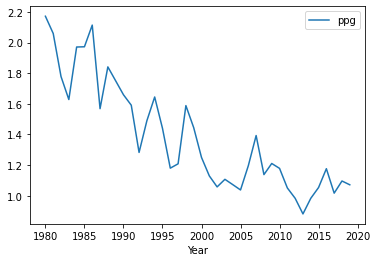

In [22]:
df_players[df_players.Rank == 1].assign(ppg=df_players.Points/df_players.Games).plot(x='Year', y='ppg');

The above graph is not surprising considering the development of modern hockey in which scoring has become increasingly difficult. It remains to add the top scorers as a feature to our DataFrame. We do this by indicating for each of the top 6 teams whether that team contains any of the rank 1-3 scorers. But first we have to remember to unify the team names.

In [23]:
df_players.loc[df_players.Team == 'JyP HT', 'Team'] = 'JYP'
set(df_players.Team.unique()) - set(df.Team.unique())

set()

Good, it looks like there are no erroneous team names in our player table.

### 1.3 Regular season game results<a id='1-3'></a>

The final type of data that we look at are the results of each game from the regular season. We use this to create a feature, which indicates how many wins each team has in the final 3 games leading to playoffs. This should tell us whether any of the teams enter the playoffs "on a streak". Most of the preprocessing is done in analogous way to sections 1.1 and 1.2 so we won't comment on it as much here.

In [24]:
games_data_file_name = 'liiga_stats_games_20210530_121423.pkl'

with open(games_data_file_name, 'rb') as f:
    games_data = pickle.load(f)

In [25]:
games_data.head()

,Time,Home,Away,HG,AG,Year,Series
Index,,,,,,,
1,19800928,HIFK,Ilves,5,2,1980,runkosarja
2,19800928,Lukko,Jokerit,1,7,1980,runkosarja
3,19800928,Kiekkoreipas,Kärpät,3,4,1980,runkosarja
4,19800928,SaiPa,TPS,4,3,1980,runkosarja
5,19800928,Tappara,Ässät,7,5,1980,runkosarja


In [26]:
df_games = games_data.drop(columns=['Series']).reset_index(drop=True)
num_cols = ['HG', 'AG', 'Year']
str_cols = ['Home', 'Away']
df_games[num_cols] = df_games[num_cols].apply(pd.to_numeric)
df_games['Time'] = df_games['Time'].apply(pd.to_datetime)
df_games[str_cols] = df_games[str_cols].astype('string')
df_games.head()

,Time,Home,Away,HG,AG,Year
0,1980-09-28,HIFK,Ilves,5,2,1980
1,1980-09-28,Lukko,Jokerit,1,7,1980
2,1980-09-28,Kiekkoreipas,Kärpät,3,4,1980
3,1980-09-28,SaiPa,TPS,4,3,1980
4,1980-09-28,Tappara,Ässät,7,5,1980


We want to create a function which, given a Team and a Year, returns a series with results for the final 3 games of the season for that team.

In [27]:
game_ex = (df_games[(df_games.Year == 1987) & ((df_games.Home == 'Tappara') | (df_games.Away == 'Tappara'))]
           .sort_values('Time', ascending=False).head(3))
game_ex

,Time,Home,Away,HG,AG,Year
1528,1988-03-27,Tappara,JyP,5,3,1987
1520,1988-03-24,HIFK,Tappara,6,4,1987
1517,1988-03-20,KooKoo,Tappara,3,7,1987


Now, for each of these games we need to decide whether Tappara won it or not. We treat draws and losses equally.

In [28]:
def win_from_game(r, team):
    if (r.Home == team and r.HG > r.AG) or (r.Away == team and r.AG > r.HG):
        return 1
    else:
        return 0

def wins_for_year(df, team, year):
    # Extract a subtable with the last 3 games for the given team and year:
    games = (df[(df.Year == year) & ((df.Home == team) | (df.Away == team))]
             .sort_values('Time', ascending=False).head(3))
    games.index = ['G1', 'G2', 'G3']
    games = games.apply(lambda x: win_from_game(x, team=team), axis=1)
    return games
    
wins_for_year(df_games, 'Tappara', 1987)

G1    1
G2    0
G3    1
dtype: int64

Here `G1` corresponds to the result (1 for win) of the last game of the season, `G2` the penultimate game and so on.

### 1.4 Target variable<a id='1-4'></a>

Finally we have to create the target variable (i.e. the champion of each year) that we want to predict. We'll have to rely on Wikipedia for this since this data is surprisingly not available in a uniform format on Liiga's website. For this we'll do a simple scrape with `BeautifulSoup` (compare how much more straightforward this is versus what we had to do with `LiigaScraper` in `liiga_scraper.py`).

In [29]:
w_html = requests.get('https://en.wikipedia.org/wiki/Liiga')
soup = BeautifulSoup(w_html.text, 'html.parser')

header = soup.find('span', id='Previous_SM-liiga/Liiga_playoff_winners_(Finnish_Champions)')
winners_table = header.find_next('table')

y = []
for entry in winners_table.find_all('li'):
    try:
        year, team = entry.get_text().split(' – ')  # Notice the dash is \u2013
        y.append([year, team])
    except ValueError:
        # Usually happens if some user modified the website with a different separator
        print(f"Error for {entry.get_text()}.")
        next

Error for 2021 - Lukko.


In [30]:
y = pd.DataFrame(y, columns=['Year', 'Team'])
y.tail()

,Year,Team
40,2016,Tappara
41,2017,Tappara
42,2018,Kärpät
43,2019,HPK
44,2020,(cancelled)


In [31]:
y.Year = y.Year.astype('int')
y.Team = y.Team.astype('string')
y.dtypes

Year     int64
Team    string
dtype: object

After inspecting the data from Wikipedia, we spot a small "gotcha": we have chosen to label our seasons by the year in which they begin, but in the data we just scraped the winner is given for the year in which the season finishes. We'll fix that below and also drop row 44 which is our missing data point that we eventually want to predict (winner for the season 2019).

In [32]:
y.drop(y.index[y.Year == 2020], inplace=True)
y.Year = y.Year - 1
y = y[y.Year >= 1980].reset_index(drop=True)
y = y.set_index('Year')

Finally we create the actual feature we want to predict, i.e. the regular season rank of the winner:

In [33]:
y['SeasonRank'] = top6_by_year.apply(lambda x: x == y.loc[x.name].Team, axis=1).idxmax(axis=1)
y.head()

,Team,SeasonRank
Year,,
1980,Kärpät,3
1981,Tappara,3
1982,HIFK,2
1983,Tappara,1
1984,Ilves,3
